# Orchard's algorithm for fast nearest neighbour calculation

### Imports

In [1]:
import numpy as np
from random import random
import matplotlib.pyplot as plt
from datetime import datetime
import operator
import functools

from sklearn.neighbors import NearestNeighbors

### Utility functions

In [2]:
def random_point(dimensions=2):
    return np.random.rand(dimensions)

def dist(x, y, _norm=np.linalg.norm):
    return _norm(x - y)


### Orchard's method class

In [3]:
class orchard_nn:
    def __init__(self, candidates, distance):
        """
        Args:
            candidates: list of candidates to be assessed
            distance: function to calculate distances between given pairs of points
        """
        
        self.candidates = candidates
        self.distance = distance
        
        self.num_points = len(candidates)
        
        # Precompute all distance pairs
        # e.g. self.precomp_distances[i][j] = distance from i to j
        self.precomp_distances = [[self.distance(x,y) for y in self.candidates] for x in self.candidates]
        
        # For each candidate, compute a list of all other points sorted by distance
        self.ordered_lists = [np.argsort(self.precomp_distances[x]) for x in range(len(candidates))]
        
    def nearest_neighbour(self, query, verbose=True):
        """
        Args: 
            query: the query point
        Returns:
            the nearest neighbour for the query point
        """
        
        # used to avoid repeatedly checking the same point
        tested = [False] * self.num_points
        
        # pick a random point as our best guess
        start_index = np.random.randint(self.num_points)
        
        # say the best index, distance, and corresponding list of distances correspond to this random point
        best_index = start_index
        best_distance = self.distance(query, self.candidates[best_index])
        
        
        i = 0
        while (i < self.num_points): # until we reach the end of the current list
            if best_distance <= (0.5 * self.precomp_distances[best_index][self.ordered_lists[best_index][1]]):
                # This checks if the distance from our query to our best guess is < half
                # the distance from our best guess to its nearest neighbour
                # if so, our best guess is the optimal candidate as all other points must be 
                #further from our query
                break
                
            else:
                # Equally, if we get to the end of the ordered list for the candidate without finding a better
                # distance, then this candidate was the nearest neighbour

                node = self.ordered_lists[best_index][i]

                #this condition avoids unnecessarily checking candidates multiple times
                if tested[node] == False:
                    tested[node] = True
                    
                    query_distance = self.distance(query, self.candidates[node])

                    if query_distance < best_distance:
                        # if True, we've found a nearer neighbour and we assign the index and distance accordingly
                        best_index = node
                        best_distance = query_distance

                        # set i=0 to move to the start of the list of distances for this new best guess
                        i=0

                    else:
                        # look at the next point in the ordered list of neighbours
                        i += 1
                else:
                   #  if we have already tested this point, move on to the next one
                    i += 1

        if verbose:   
            print("Query point: {}".format(query))
            print("Nearest neighbour to query is point {}: {}".format(best_index, self.candidates[best_index]))
            print("Distance: {}".format(best_distance))

        return self.candidates[best_index]
    

## Testing

In [4]:
# Create random points
points = np.asarray([random_point(dimensions=2) for n in range(10000)])
query_points = np.asarray([random_point(dimensions=2) for n in range(10000)])

query_point = query_points[0]

In [5]:
# initialise orchard's algorithm
start = datetime.now()
orchard = orchard_nn(points, dist)
end = datetime.now()
print("pre-computation time: {}".format(end - start))

pre-computation time: 0:06:49.134175


In [6]:
# find nearest neighbour to query point
start = datetime.now()
neighbour = orchard.nearest_neighbour(query_point)
end = datetime.now()
print("Time for 1 query: {}".format(end-start))

Query point: [0.18499699 0.97828844]
Nearest neighbour to query is point 775: [0.18175959 0.9852349 ]
Distance: 0.007663815484185155
Time for 1 query: 0:00:00.076116


In [7]:
# perform a large numbver of queries:

orch_times = []

for q in query_points:
    start = datetime.now()
    neighbour = orchard.nearest_neighbour(q, verbose=False)
    end = datetime.now()
    orch_times.append(end-start)
print("Total time for {} queries: {}".format(len(query_points), functools.reduce(operator.add, orch_times)))

Total time for 10000 queries: 0:06:18.759661


### Plot results

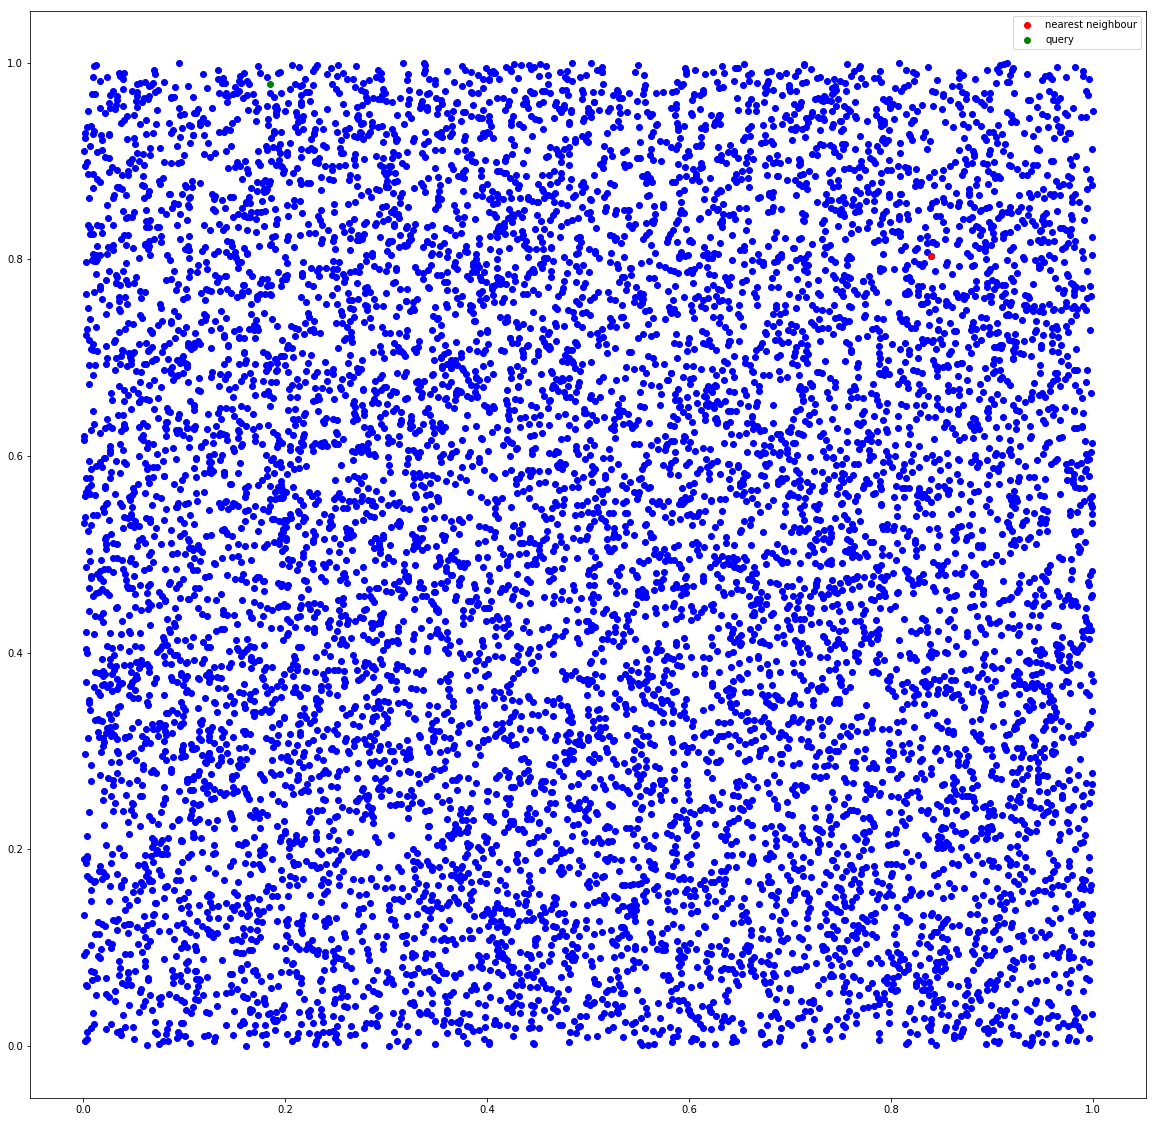

In [8]:
plt.figure(figsize=(20,20))
plt.scatter(points[:,0], points[:,1], c='b')
plt.scatter(neighbour[0], neighbour[1], c='r', label='nearest neighbour')
plt.scatter(query_point[0], query_point[1], c='g', label='query')
plt.legend()
plt.show()
plt.close()

### Comparison to vanilla K-NN

In [9]:
# Fit sklearn KNN classifier
start = datetime.now()
sk_knn = NearestNeighbors(n_neighbors=1)
sk_knn.fit(points) 
end = datetime.now()
print("Time to fit SKLearn KNN: {}".format(end-start))

Time to fit SKLearn KNN: 0:00:00.008174


In [10]:
start = datetime.now()
sk_neighbour_distance, sk_neighbour = sk_knn.kneighbors([query_point])
sk_knn.fit(points) 
end = datetime.now()
print("Query point: {}".format(query_point))
print("Nearest neighbour to query is point {}: {}".format(sk_neighbour[0][0], orchard.candidates[sk_neighbour][0][0]))
print("Distance: {}".format(sk_neighbour_distance))
print("Time for 1 query: {}".format(end-start))


Query point: [0.18499699 0.97828844]
Nearest neighbour to query is point 775: [0.18175959 0.9852349 ]
Distance: [[0.00766382]]
Time for 1 query: 0:00:00.007081


In [11]:
sk_neighbour[0][0]

775

In [13]:
sk_times = []
for q in query_points:
    start = datetime.now()
    sk_neighbour_distance, sk_neighbour = sk_knn.kneighbors([q])
    end = datetime.now()
    sk_times.append(end-start)
print("Total time for {} queries: {}".format(len(query_points), functools.reduce(operator.add, sk_times)))

Total time for 10000 queries: 0:00:01.481603
